## Load Data and Initial Grid Search

In [10]:
DATA_NAME = 'full-pastis-wavelet-gray' # size-name-transform-channel

In [11]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
CWD

'/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/results/case-studies/pastis/wavelet/full/gray'

In [12]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [13]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'full-pastis-wavelet-gray-size.pickle'))

GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
group_data_map

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -43.34915759, -36.2290875 , ...,  36.11999915,
         38.35812055,  42.17747737]),
 6: array([-23.87540781, -23.66829959, -23.29668418, ...,  25.41955052,
         31.52717851,  44.79754701]),
 7: array([-19.12997336, -18.52962064, -17.2224645 , ...,  16.63923718,
         17.96650462,  20.30569957]),
 8: array([-18.71256003, -17.84609759, -16.94317757, ...,  15.43083627,
         16.78232461,  20.5891778 ])}

In [14]:
def create_kurt_var_ksstat_df(cdf_dict):
    cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(cdf_dict.items())})
    cdfs_df['r'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[0])
    cdfs_df['eta'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[1])
    cdfs_df['cdf'] = pd.Series(cdfs_df["(r,eta),cdf"].str[1])
    cdfs_df['variance'] = np.nan_to_num(cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
    cdfs_df['kurtosis'] = cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
    return cdfs_df

In [15]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:817: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:822: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:822: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:822: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamm

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


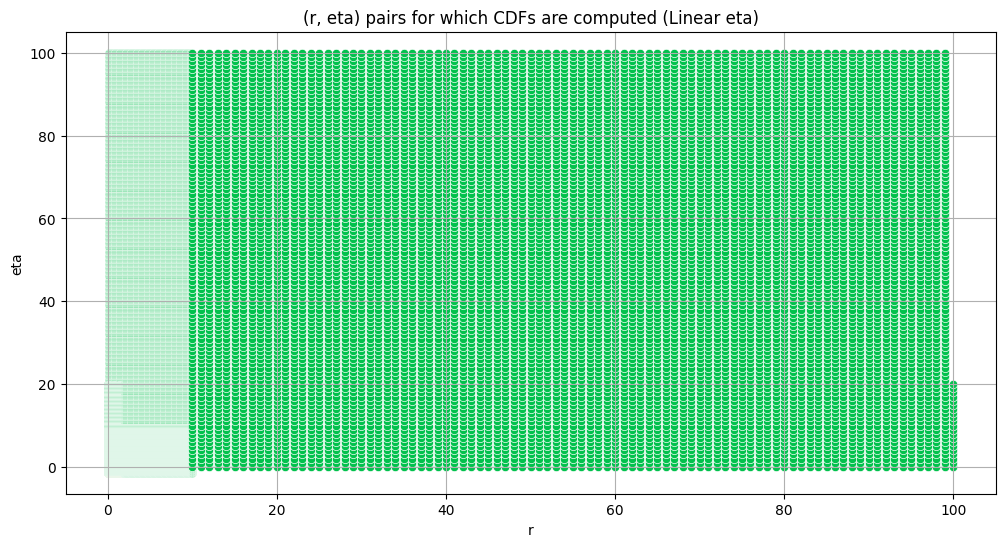

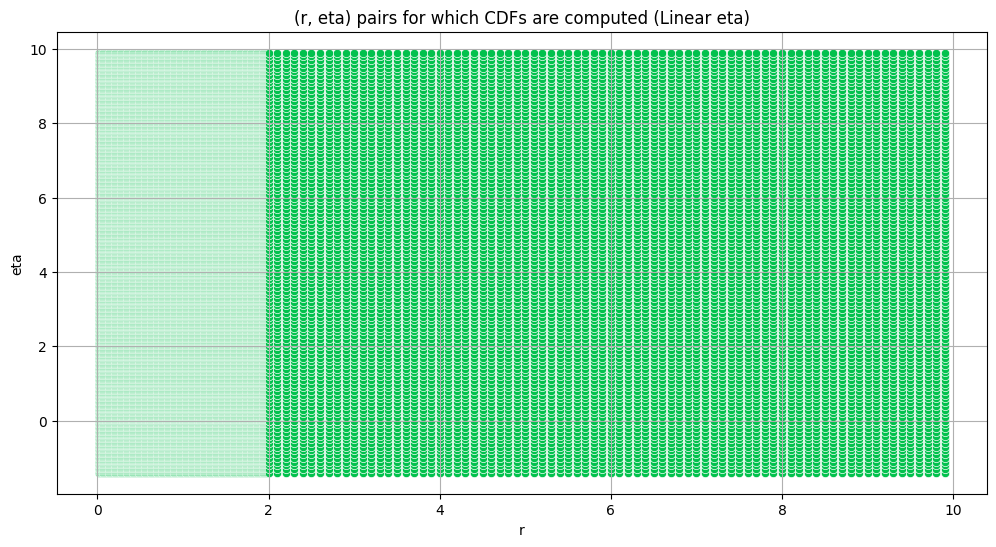

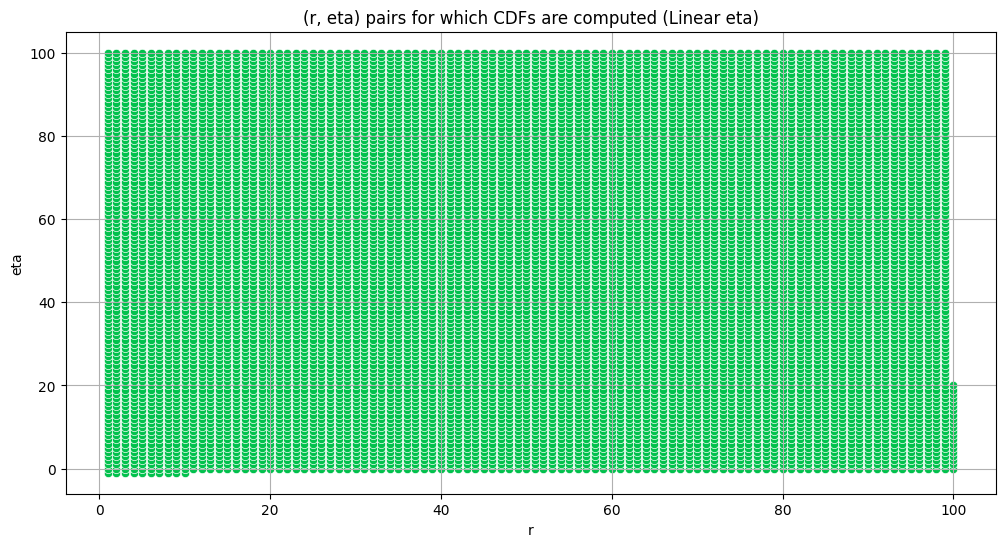

/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,r,eta,variance,kurtosis
count,51883.000000,51883.000000,5.188300e+04,5.064200e+04
mean,11.990701,21.476312,inf,inf
std,22.639851,28.237512,inf,NaN
min,0.020000,-1.400000,0.000000e+00,4.787254e-04
25%,1.000000,3.000000,9.882555e-01,1.513901e-02
50%,1.970000,7.600000,1.482803e+00,1.950077e-01
75%,8.100000,32.000000,5.742021e+00,6.565170e-01
max,100.000000,100.000000,1.797693e+308,inf


In [16]:
create_scatter_plot(all_cdfs_df)
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 10) & (all_cdfs_df['eta'] < 10)])
create_scatter_plot(coarse_cdf_df)

all_cdfs_df.describe()

In [17]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [18]:
''' Only need to run commented code once'''    
# for group in  GROUPS:
#     print(f'{GROUP.capitalize()} {group}')
#     obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
#                                                                              n_bootstrap=n_bootstrap, 
#                                                                              bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
#                                                                              metric= np.var, 
#                                                                              ci=ci)
#     obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
#                                                                                  n_bootstrap=n_bootstrap, 
#                                                                                  bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
#                                                                                  metric= stats.kurtosis, ci=ci)  
#     master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
#     master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
#     master_df.loc[group, 'total_samples'] = group_total_samples[group]

# master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
var_kurt_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0


In [19]:
def add_tests_to_df(cdfs_df, group, var_kurt_df, ksstats):
    cdfs_df['pass_var'] = (cdfs_df['variance'] > var_kurt_df.loc[group, 'var_lower']) & (cdfs_df['variance'] < var_kurt_df.loc[group, 'var_upper'])
    cdfs_df['pass_kurt'] = (cdfs_df['kurtosis'] > var_kurt_df.loc[group, 'kurt_lower']) & (cdfs_df['kurtosis'] < var_kurt_df.loc[group,'kurt_upper'])
    cdfs_df['ksstat'] = ksstats
    cutoff = stats.kstwo(n=var_kurt_df.loc[group, 'total_samples']).isf(0.05)
    cdfs_df['pass_kstest'] = cdfs_df['ksstat'].apply(lambda x: True if x < cutoff else False)
    return cdfs_df

####
Layer  2


100%|██████████| 51883/51883 [00:07<00:00, 6623.54it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 3180, Without approximation : 3180.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


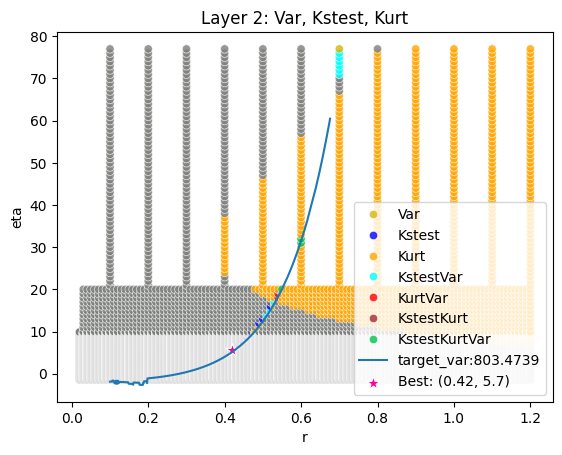

####
Layer  3


100%|██████████| 51883/51883 [00:24<00:00, 2133.51it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 12720, Without approximation : 12720.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


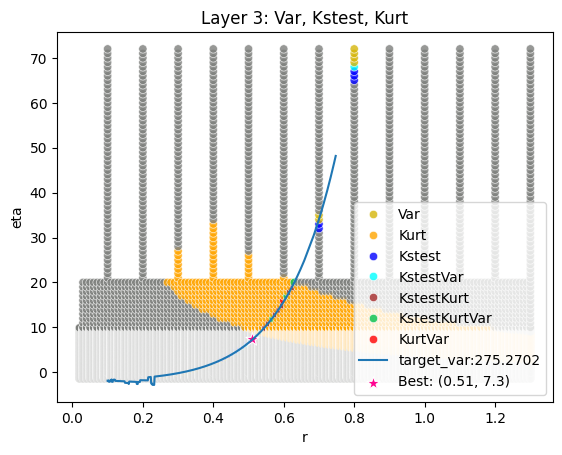

####
Layer  4


100%|██████████| 51883/51883 [01:30<00:00, 572.38it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 50880, Without approximation : 50880.0


/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


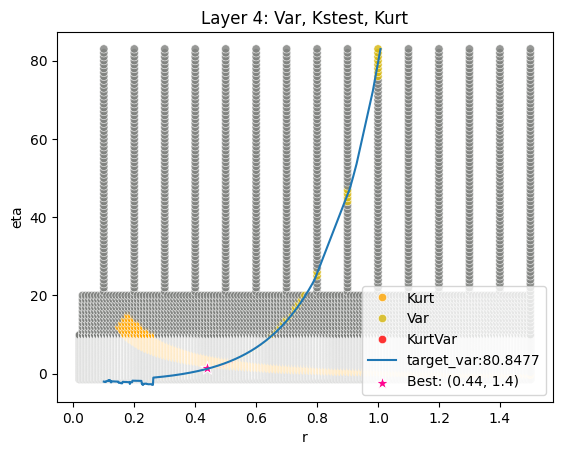

####
Layer  5


100%|██████████| 51883/51883 [05:43<00:00, 151.25it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 203520, Without approximation : 203520.0


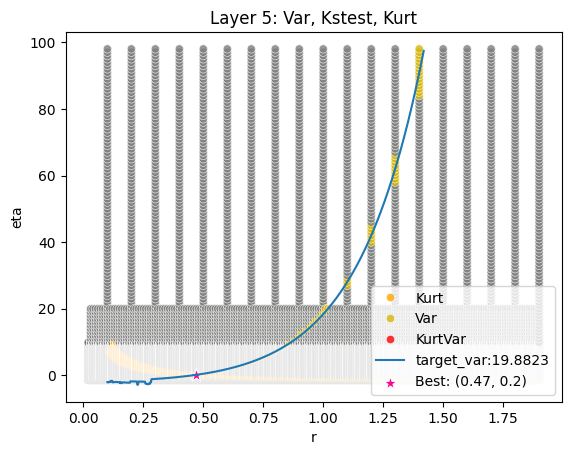

####
Layer  6


100%|██████████| 51883/51883 [22:55<00:00, 37.71it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 814080, Without approximation : 814080.0


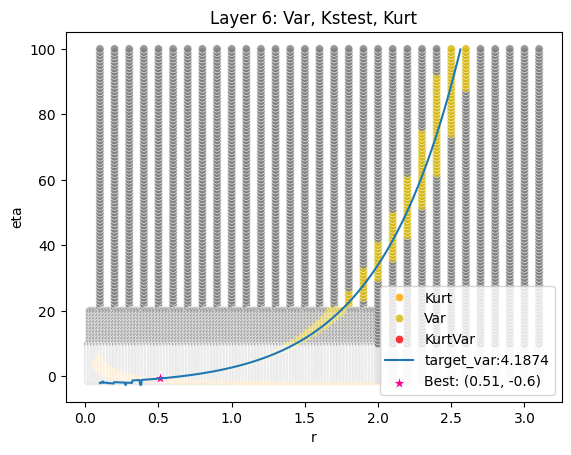

####
Layer  7


100%|██████████| 51883/51883 [1:31:14<00:00,  9.48it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 3256320, Without approximation : 3256320.0


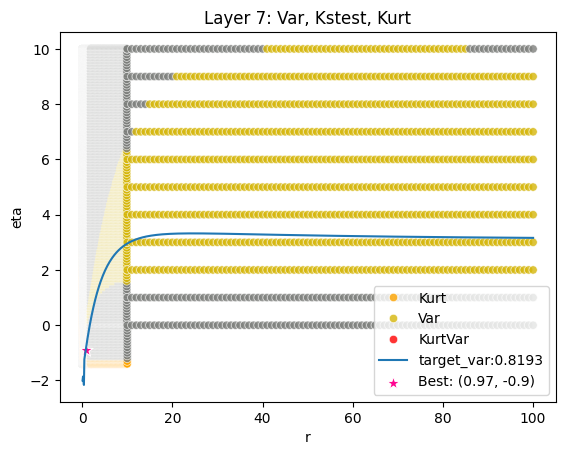

####
Layer  8


100%|██████████| 51883/51883 [6:42:19<00:00,  2.15it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 13025280, Without approximation : 13025280.0


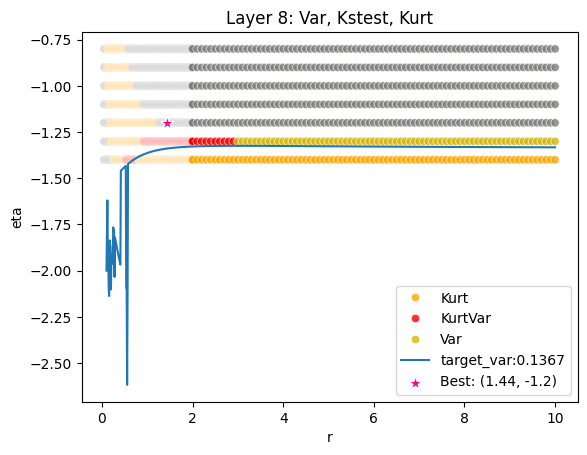

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,0.024030
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,0.012029
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,0.006018
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005235,0.003010
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004347,0.001505
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010412,0.000753
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051527,0.000376


In [20]:
''' Only need to run commented code once'''
sorted_params = sorted(all_cdfs)
group_cdf_df_dict = dict()

for i, group in enumerate(GROUPS):
    print(f"####\n{GROUP.capitalize()} ", group)
    sample = group_data_map[group]
    group_cdf_df = all_cdfs_df.copy()
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
    master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
    print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
    master_df.loc[group, 'kstest_stat_initial'] = min_stat
    cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

    group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
    
    group_cdf_df_dict[group] = group_cdf_df
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']

    fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                          plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                          target_var = master_df.loc[group, 'obs_var'],
                          best_param = initial_param)
    
    fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

    # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
    # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

    # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_var)
    # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_kurt)

master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"), index_col=GROUP)
master_df

In [21]:
''' Only need to run commented code once'''
best_params_eta0 = []
for i, group in enumerate(GROUPS):
    if master_df.loc[group, 'initial_eta'] != 0:
        sample = group_data_map[group]
        group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
        cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
        ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
        best_params_eta0.append(best_param_eta0[0])
        master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
    else:
        master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
        best_params_eta0.append(master_df.loc[group, 'initial_r'])
master_df['best_r_eta0'] = best_params_eta0
master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"), index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 1337.62it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 2013.07it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 548.07it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 149.10it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:10<00:00, 36.17it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:39<00:00,  9.44it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [02:53<00:00,  2.13it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,0.024030,0.060346,0.26
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,0.012029,0.037012,0.29
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,0.006018,0.023319,0.34
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005235,0.003010,0.005653,0.44
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004347,0.001505,0.020504,0.74
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010412,0.000753,0.082283,6.10
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051527,0.000376,0.227353,6.00


In [22]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2
(0.412, 5.69), 50 of 420
(0.414, 5.79), 100 of 420
(0.417, 5.69), 150 of 420
(0.419, 5.79), 200 of 420
(0.422, 5.69), 250 of 420
(0.424, 5.79), 300 of 420
(0.427, 5.69), 350 of 420
(0.429, 5.79), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 7137.77it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 2 best parameters: ((0.42, 5.68), 0.017541840618859696)
(0.4191, 5.681), 450 of 840
(0.4194, 5.671), 500 of 840
(0.4196, 5.681), 550 of 840
(0.4199, 5.671), 600 of 840
(0.4201, 5.683), 650 of 840
(0.4204, 5.673), 700 of 840
(0.4206, 5.683), 750 of 840
(0.4209, 5.673), 800 of 840


100%|██████████| 834/834 [00:00<00:00, 4357.12it/s]


Finding Minimum after computing 834 CDFs
Iter 2 layer 2 best parameters: ((0.42, 5.679), 0.017519866326516365)


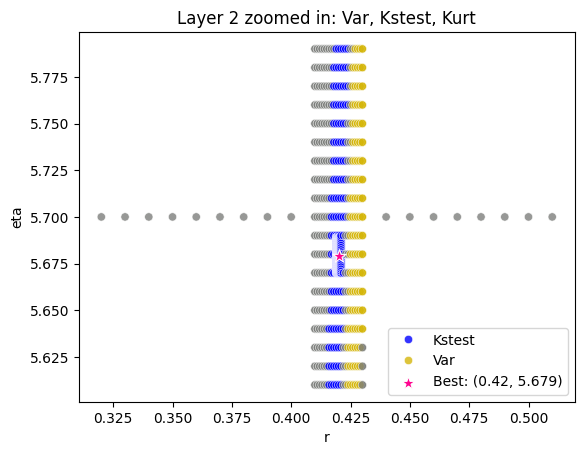

Layer 3
(0.502, 7.29), 50 of 420
(0.504, 7.39), 100 of 420
(0.507, 7.29), 150 of 420
(0.509, 7.39), 200 of 420
(0.512, 7.29), 250 of 420
(0.514, 7.39), 300 of 420
(0.517, 7.29), 350 of 420
(0.519, 7.39), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 1375.18it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 3 best parameters: ((0.509, 7.22), 0.004263263762185443)
(0.5081, 7.221), 450 of 840
(0.5084, 7.211), 500 of 840
(0.5086, 7.221), 550 of 840
(0.5089, 7.211), 600 of 840
(0.5091, 7.223), 650 of 840
(0.5094, 7.213), 700 of 840
(0.5096, 7.223), 750 of 840
(0.5099, 7.213), 800 of 840


100%|██████████| 834/834 [00:00<00:00, 1339.91it/s]


Finding Minimum after computing 834 CDFs
Iter 2 layer 3 best parameters: ((0.5089, 7.211), 0.004221089215717844)


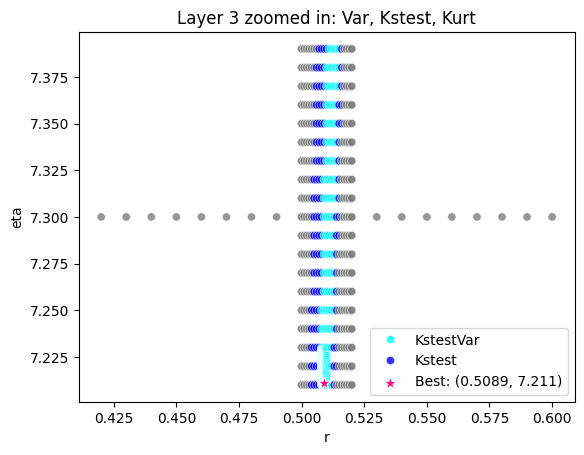

Layer 4
(0.432, 1.37), 50 of 441
(0.434, 1.45), 100 of 441
(0.437, 1.32), 150 of 441
(0.439, 1.4), 200 of 441
(0.441, 1.48), 250 of 441
(0.444, 1.35), 300 of 441
(0.446, 1.43), 350 of 441
(0.449, 1.3), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 371.69it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 4 best parameters: ((0.436, 1.31), 0.005315234043698491)
(0.435, 1.309), 450 of 882
(0.4352, 1.319), 500 of 882
(0.4355, 1.306), 550 of 882
(0.4357, 1.314), 600 of 882
(0.436, 1.302), 650 of 882
(0.4362, 1.312), 700 of 882
(0.4364, 1.32), 750 of 882
(0.4367, 1.307), 800 of 882
(0.4369, 1.315), 850 of 882


100%|██████████| 873/873 [00:02<00:00, 372.23it/s]


Finding Minimum after computing 873 CDFs
Iter 2 layer 4 best parameters: ((0.4354, 1.3), 0.005286301716882269)


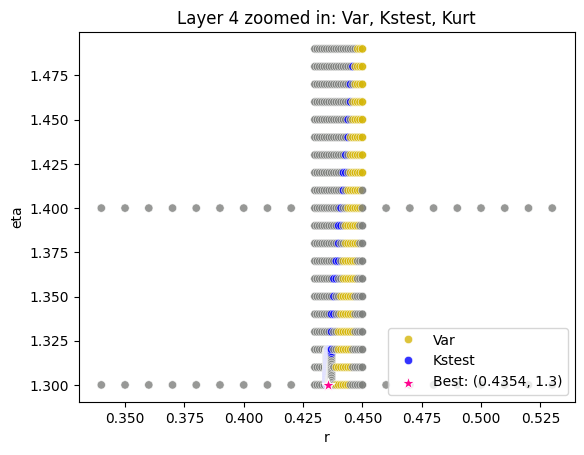

Layer 5
(0.462, 0.17), 50 of 441
(0.464, 0.25), 100 of 441
(0.467, 0.12), 150 of 441
(0.469, 0.2), 200 of 441
(0.471, 0.28), 250 of 441
(0.474, 0.15), 300 of 441
(0.476, 0.23), 350 of 441
(0.479, 0.1), 400 of 441


100%|██████████| 441/441 [00:04<00:00, 94.59it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 5 best parameters: ((0.46, 0.12), 0.003862803022669725)
(0.459, 0.118), 450 of 882
(0.4592, 0.126), 500 of 882
(0.4595, 0.113), 550 of 882
(0.4597, 0.121), 600 of 882
(0.4599, 0.129), 650 of 882
(0.4602, 0.119), 700 of 882
(0.4604, 0.127), 750 of 882
(0.4607, 0.114), 800 of 882
(0.4609, 0.122), 850 of 882


100%|██████████| 876/876 [00:09<00:00, 94.80it/s]


Finding Minimum after computing 876 CDFs
Iter 2 layer 5 best parameters: ((0.4591, 0.11), 0.0035948860782945014)
(0.45909, 0.10992), 900 of 1317
(0.45909, 0.11), 950 of 1317
(0.45909, 0.11008), 1000 of 1317
(0.4591, 0.10997), 1050 of 1317
(0.4591, 0.11008), 1100 of 1317
(0.4591, 0.10997), 1150 of 1317
(0.4591, 0.11008), 1200 of 1317
(0.45911, 0.10995), 1250 of 1317
(0.45911, 0.11003), 1300 of 1317


100%|██████████| 938/938 [00:09<00:00, 95.28it/s]


Finding Minimum after computing 938 CDFs
Iter 3 layer 5 best parameters: ((0.4591, 0.1099), 0.003590710893849436)


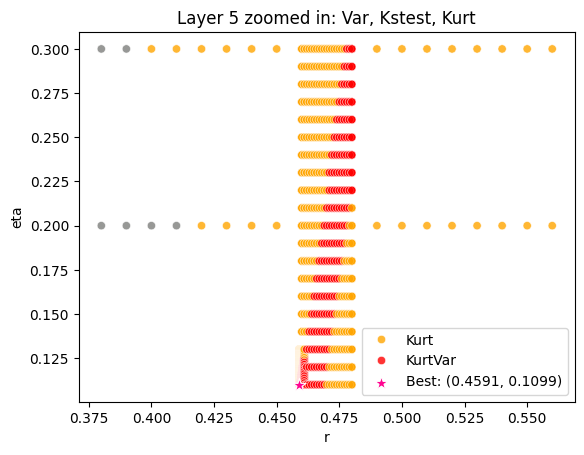

Layer 6
(0.502, -0.61), 50 of 420
(0.504, -0.51), 100 of 420
(0.507, -0.61), 150 of 420
(0.509, -0.51), 200 of 420
(0.512, -0.61), 250 of 420
(0.514, -0.51), 300 of 420
(0.517, -0.61), 350 of 420
(0.519, -0.51), 400 of 420


100%|██████████| 420/420 [00:17<00:00, 23.87it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 6 best parameters: ((0.517, -0.58), 0.003587812528338674)
(0.5161, -0.579), 450 of 861
(0.5163, -0.571), 500 of 861
(0.5166, -0.584), 550 of 861
(0.5168, -0.576), 600 of 861
(0.5171, -0.586), 650 of 861
(0.5173, -0.578), 700 of 861
(0.5175, -0.57), 750 of 861
(0.5178, -0.583), 800 of 861
(0.518, -0.573), 850 of 861


100%|██████████| 852/852 [00:35<00:00, 23.82it/s]


Finding Minimum after computing 852 CDFs
Iter 2 layer 6 best parameters: ((0.5178, -0.578), 0.0035407148747119144)
(0.51779, -0.57803), 900 of 1252
(0.51779, -0.57793), 950 of 1252
(0.5178, -0.57801), 1000 of 1252
(0.5178, -0.57808), 1050 of 1252
(0.5178, -0.57795), 1100 of 1252
(0.51781, -0.57803), 1150 of 1252
(0.51781, -0.57793), 1200 of 1252


100%|██████████| 911/911 [00:38<00:00, 23.94it/s]


Finding Minimum after computing 911 CDFs
Iter 3 layer 6 best parameters: ((0.51779, -0.57791), 0.0035360644518124262)


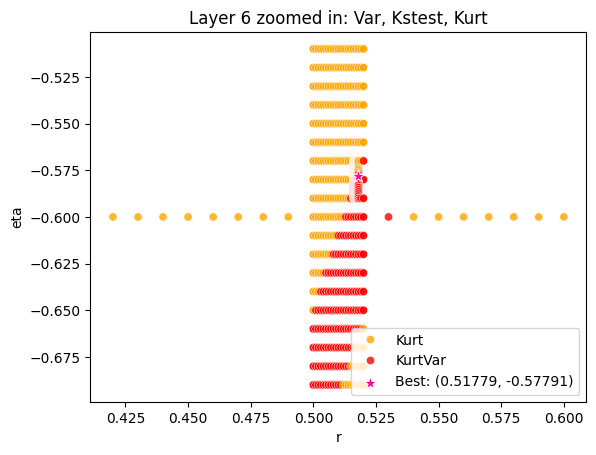

Layer 7
(0.962, -0.91), 50 of 420
(0.964, -0.81), 100 of 420
(0.967, -0.91), 150 of 420
(0.969, -0.81), 200 of 420
(0.972, -0.91), 250 of 420
(0.974, -0.81), 300 of 420
(0.977, -0.91), 350 of 420
(0.979, -0.81), 400 of 420


100%|██████████| 420/420 [01:28<00:00,  4.75it/s]


Finding Minimum after computing 420 CDFs
Iter 1 layer 7 best parameters: ((0.974, -0.9), 0.01024967921008657)
(0.9731, -0.899), 450 of 861
(0.9733, -0.891), 500 of 861
(0.9736, -0.904), 550 of 861
(0.9738, -0.896), 600 of 861
(0.9741, -0.906), 650 of 861
(0.9743, -0.898), 700 of 861
(0.9745, -0.89), 750 of 861
(0.9748, -0.903), 800 of 861
(0.975, -0.893), 850 of 861


100%|██████████| 852/852 [01:51<00:00,  7.62it/s]


Finding Minimum after computing 852 CDFs
Iter 2 layer 7 best parameters: ((0.9739, -0.9), 0.010244784639180216)
(0.97389, -0.90003), 900 of 1252
(0.97389, -0.89993), 950 of 1252
(0.9739, -0.90001), 1000 of 1252
(0.9739, -0.90008), 1050 of 1252
(0.9739, -0.89995), 1100 of 1252
(0.97391, -0.90003), 1150 of 1252
(0.97391, -0.89993), 1200 of 1252


100%|██████████| 911/911 [01:57<00:00,  7.76it/s]
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/plotting.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=0.8)


Finding Minimum after computing 911 CDFs
Iter 3 layer 7 best parameters: ((0.97389, -0.89999), 0.010243548030930305)


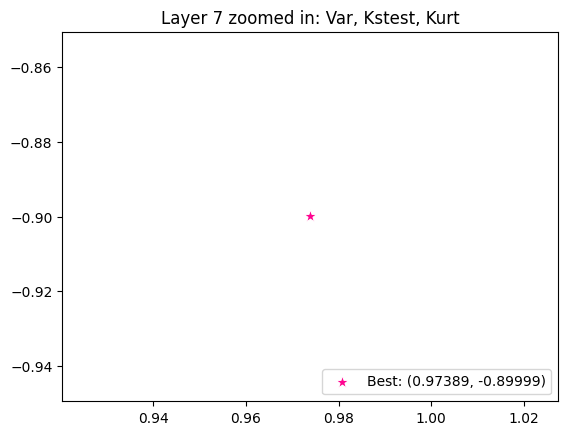

Layer 8
(1.432, -1.23), 50 of 441
(1.434, -1.15), 100 of 441
(1.437, -1.28), 150 of 441
(1.439, -1.2), 200 of 441
(1.441, -1.12), 250 of 441
(1.444, -1.25), 300 of 441
(1.446, -1.17), 350 of 441
(1.449, -1.3), 400 of 441


100%|██████████| 441/441 [04:15<00:00,  1.73it/s]


Finding Minimum after computing 441 CDFs
Iter 1 layer 8 best parameters: ((1.45, -1.22), 0.046819894366580295)
(1.449, -1.221), 450 of 861
(1.4492, -1.211), 500 of 861
(1.4495, -1.224), 550 of 861
(1.4497, -1.216), 600 of 861
(1.45, -1.228), 650 of 861
(1.4502, -1.218), 700 of 861
(1.4504, -1.21), 750 of 861
(1.4507, -1.223), 800 of 861
(1.4509, -1.215), 850 of 861


100%|██████████| 855/855 [09:17<00:00,  1.53it/s]


Finding Minimum after computing 855 CDFs
Iter 2 layer 8 best parameters: ((1.4509, -1.216), 0.0450821702755021)
(1.4509, -1.2161), 900 of 1275
(1.4509, -1.2161), 950 of 1275
(1.4509, -1.2161), 1000 of 1275
(1.4509, -1.2161), 1050 of 1275


100%|██████████| 857/857 [08:17<00:00,  1.72it/s]


Finding Minimum after computing 857 CDFs
Iter 3 layer 8 best parameters: ((1.4509, -1.2159), 0.04503941860052979)


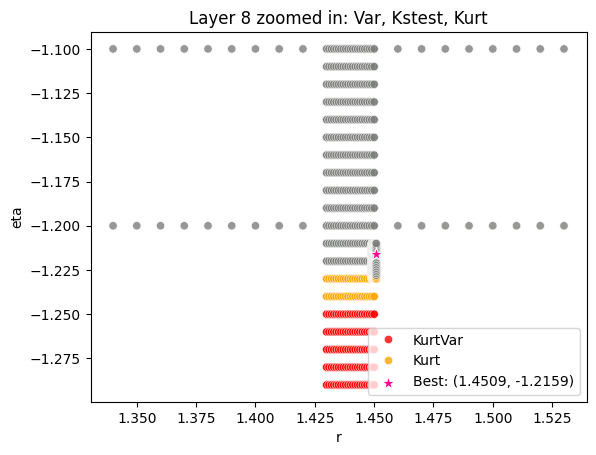

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,iter1_r,iter1_eta,kstest_stat_iter1,iter2_r,iter2_eta,kstest_stat_iter2,iter3_r,iter3_eta,kstest_stat_iter3,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,...,0.420,5.68,0.017542,0.4200,5.679,0.017520,NaN,NaN,NaN,6034
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,...,0.509,7.22,0.004263,0.5089,7.211,0.004221,NaN,NaN,NaN,108666
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,...,0.436,1.31,0.005315,0.4354,1.300,0.005286,NaN,NaN,NaN,64395
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005235,...,0.460,0.12,0.003863,0.4591,0.110,0.003595,0.45910,0.10990,0.003591,144888
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004347,...,0.517,-0.58,0.003588,0.5178,-0.578,0.003541,0.51779,-0.57791,0.003536,152640
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010412,...,0.974,-0.90,0.010250,0.9739,-0.900,0.010245,0.97389,-0.89999,0.010244,18109
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051527,...,1.450,-1.22,0.046820,1.4509,-1.216,0.045082,1.45090,-1.21590,0.045039,894


In [24]:
SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [2, 2, 2, 3, 3, 3, 3, 3]))
NUM_SAMPLES_OPTIMIZE = 2000

if SKIP_OPTIMIZE_STEP:
    master_df['kstest_stat'] = master_df['kstest_stat_initial']
    master_df[f'best_r'] = master_df['initial_r']
    master_df[f'best_eta'] = master_df['initial_eta']
else:
    for group in GROUPS: 
        print(f"{GROUP.capitalize()} {group}")
        sample = group_data_map[group]
        initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
        r_granularity = 10
        eta_granularity = 10
        for i in range(-1, -5, -1):
            if tuple([round_to_sigfigs(initial_r + 10.**i), initial_eta]) in all_cdfs:
                r_granularity = 10.**i
            if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i)]) in all_cdfs:
                
                eta_granularity = 10.**i

        for d in range(1, NUM_ITERS[group] + 1):
            if d == 1:
                initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            else:
                initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
            r_granularity = r_granularity * 10.0**(-d+1) 
            eta_granularity = eta_granularity * 10.0**(-d+1) 

            r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
            eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
            simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
            cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
            ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

            temp_df = create_kurt_var_ksstat_df(cdfs_dict)
            temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
            group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
            master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
            master_df.loc[group, 'kstest_stat_best'] = kstest_stat
            master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
            master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
            
            print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

        temp_df = group_cdf_df_dict[group]
        eps = 0.1
        filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                        (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                        (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                        (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']
        fig = combo_test_plot(filtered_df, cols, 
                              plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                              best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
        fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
        
master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', f'best_r', f'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'), index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

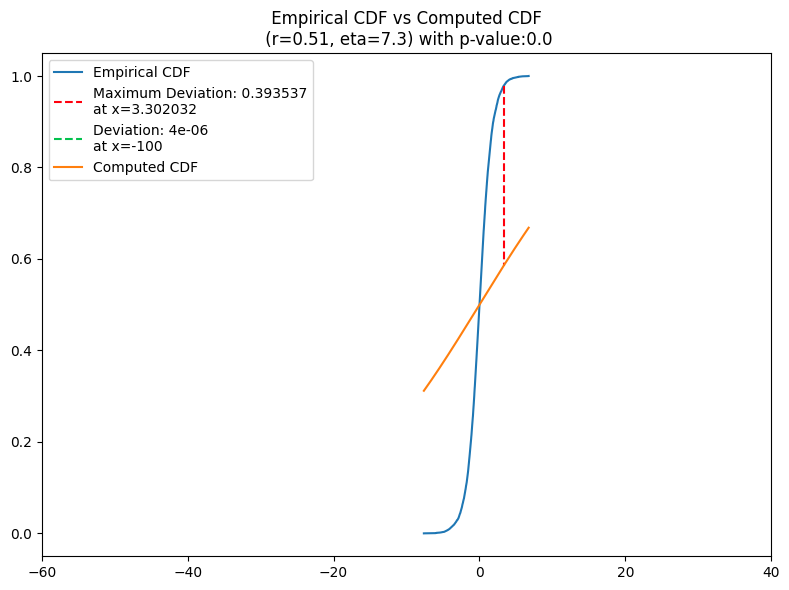

In [25]:
# Example Cell
group = 3
visualize_cdf(sample = sample_prior(1, 1, 10000), 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

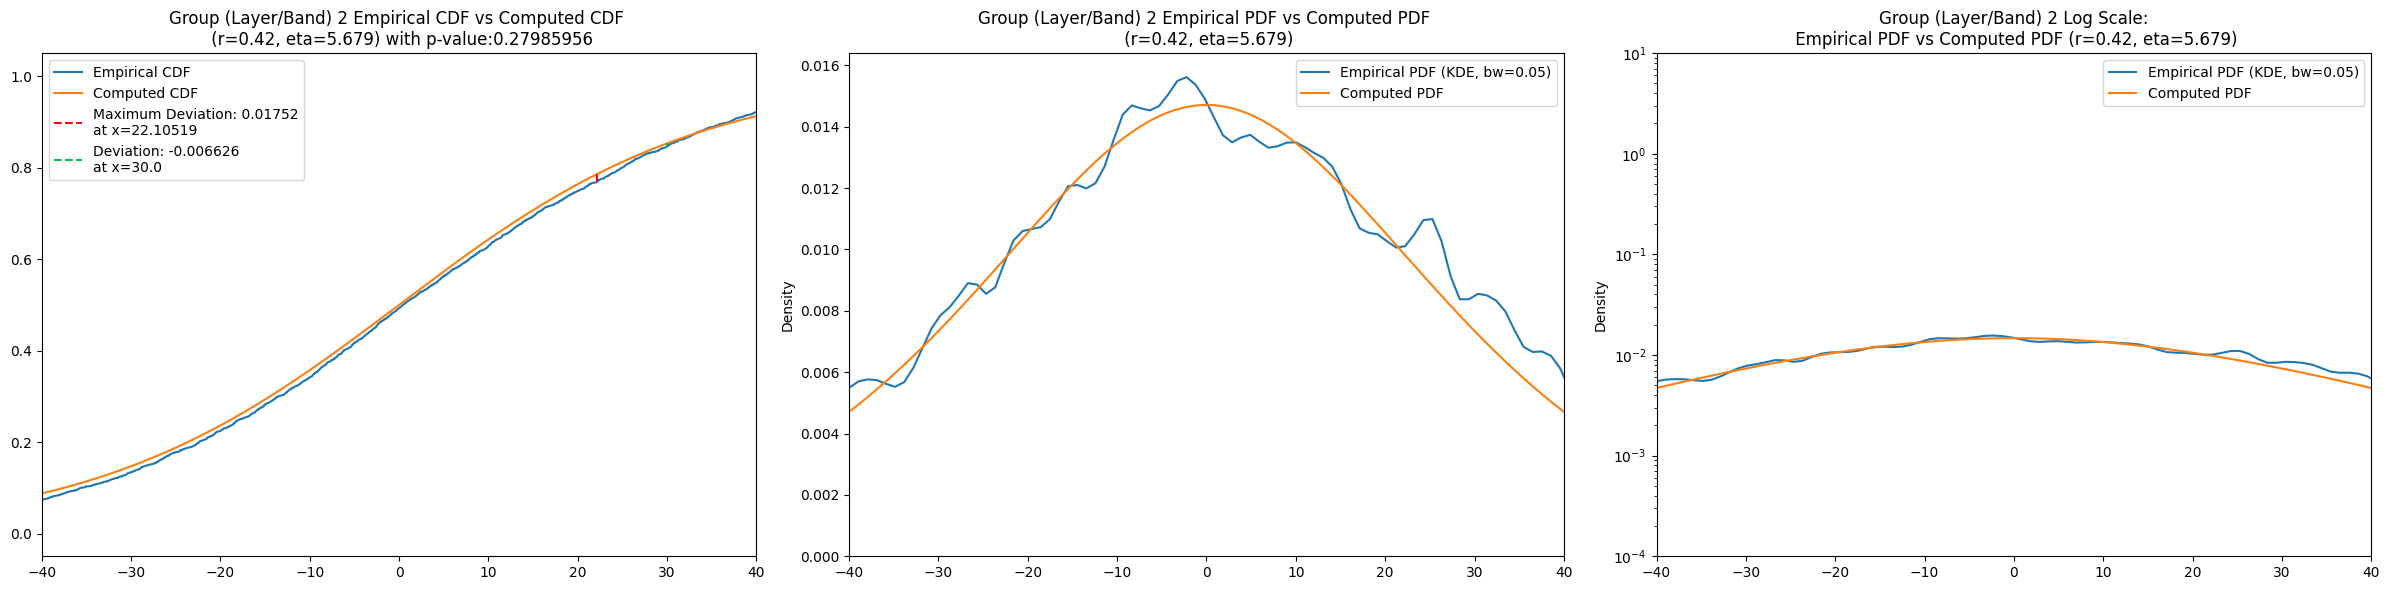

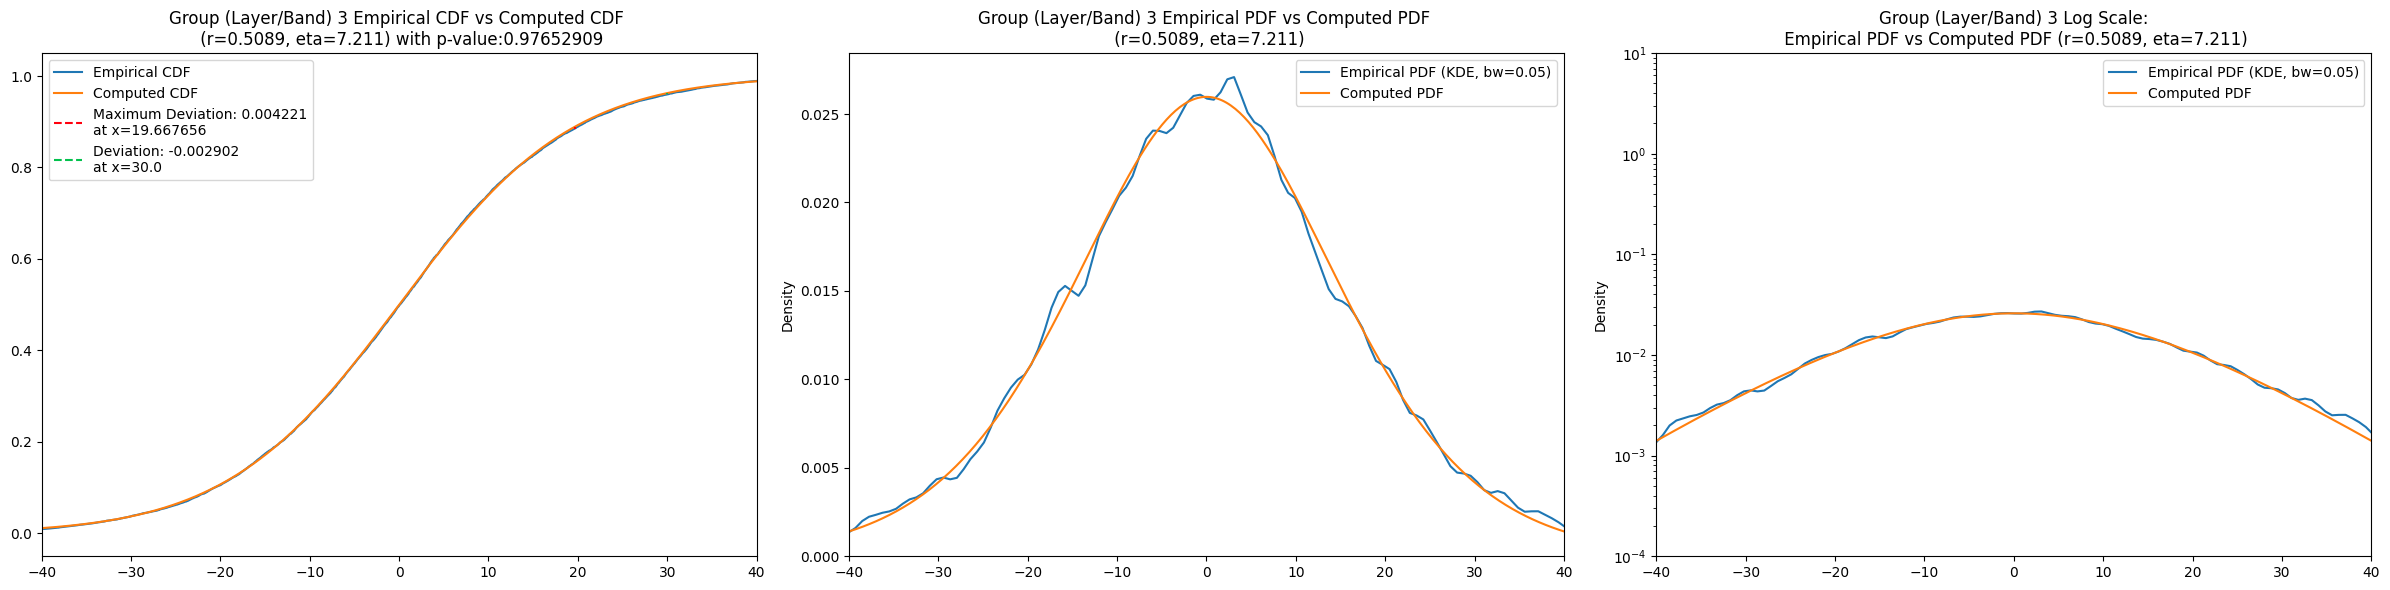

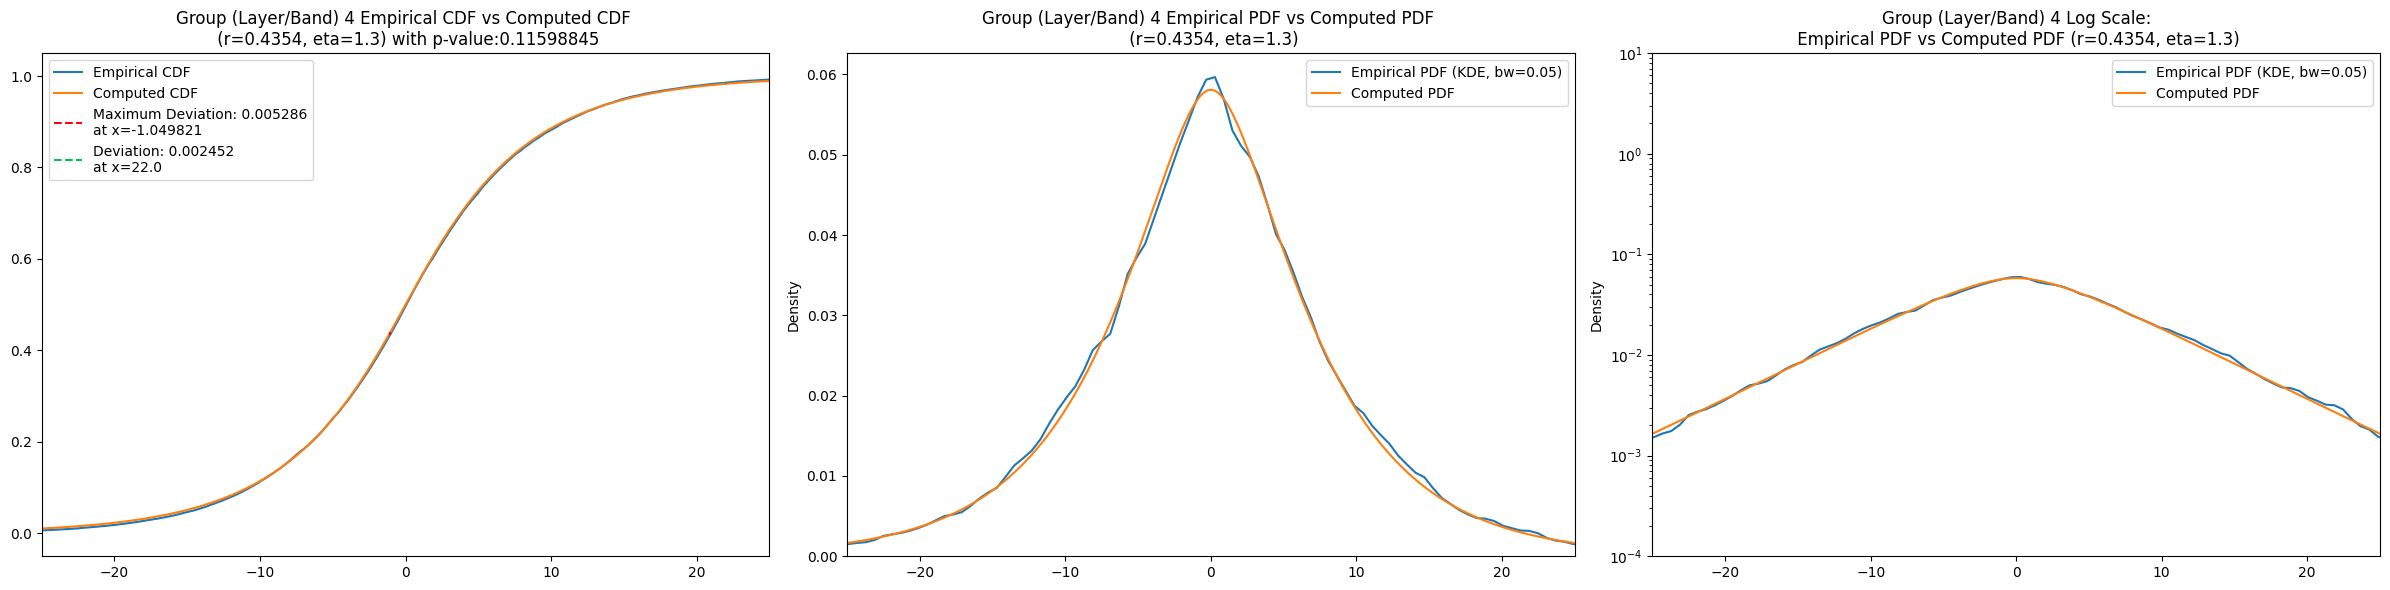

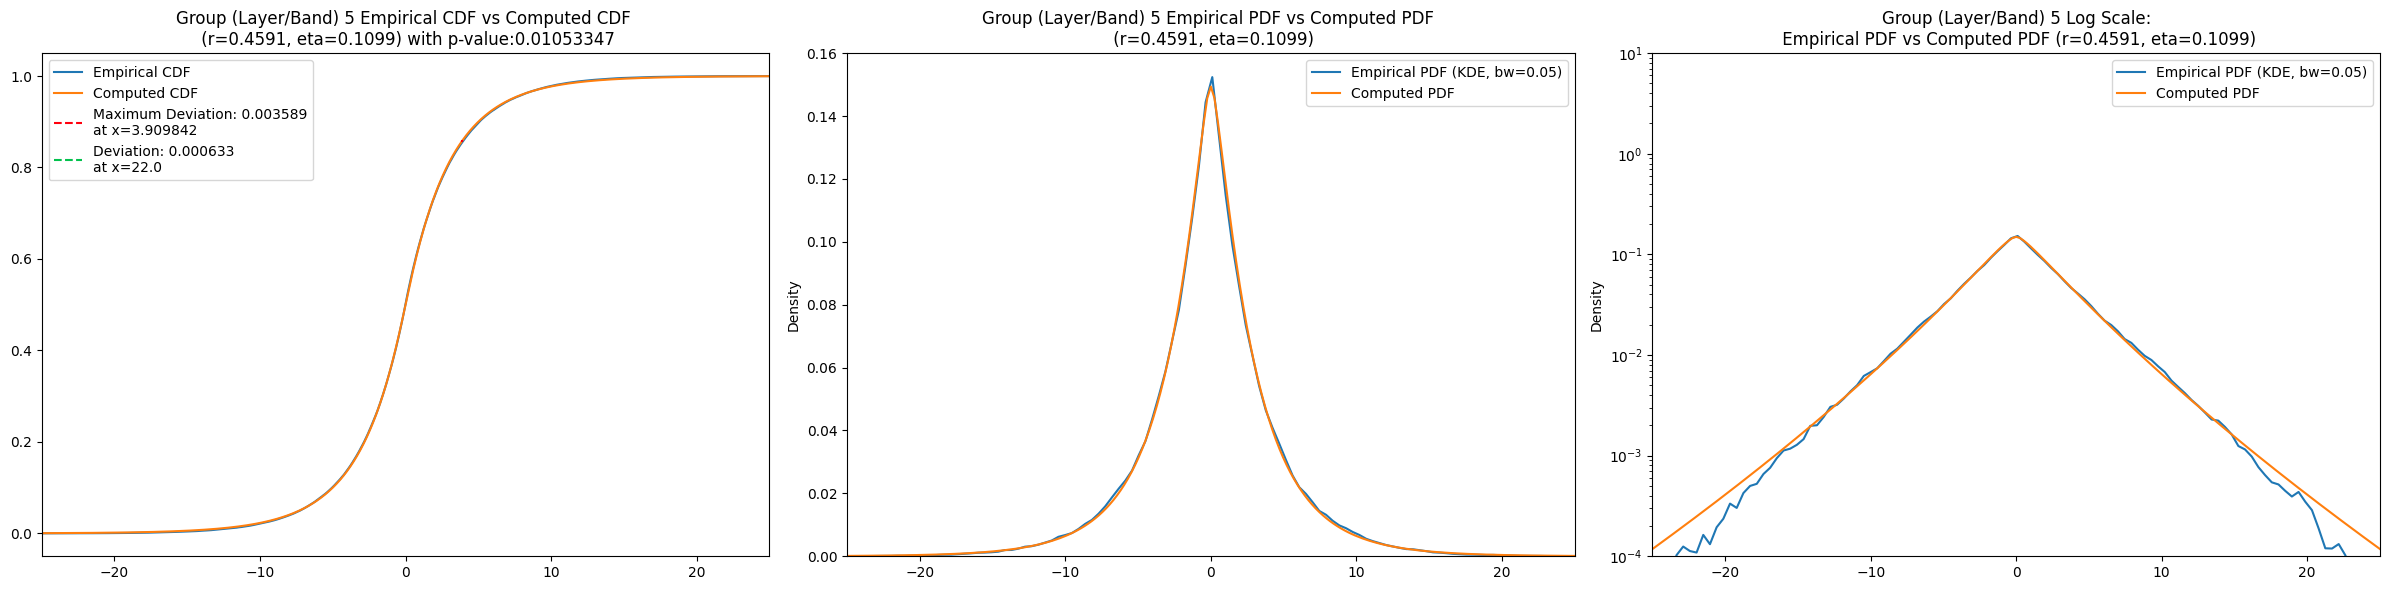

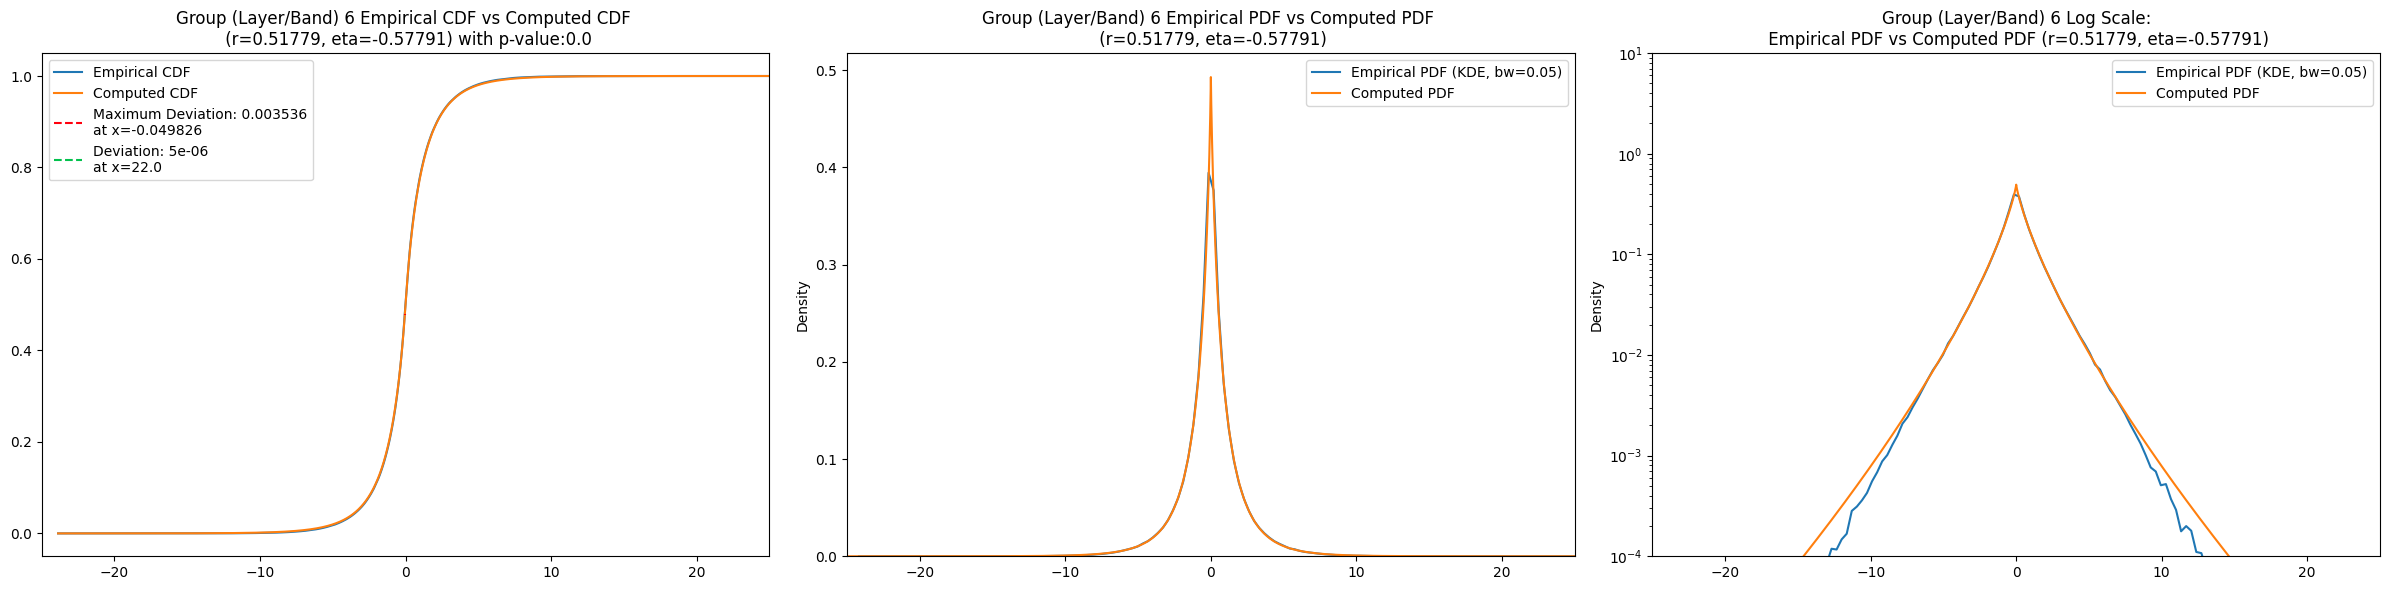

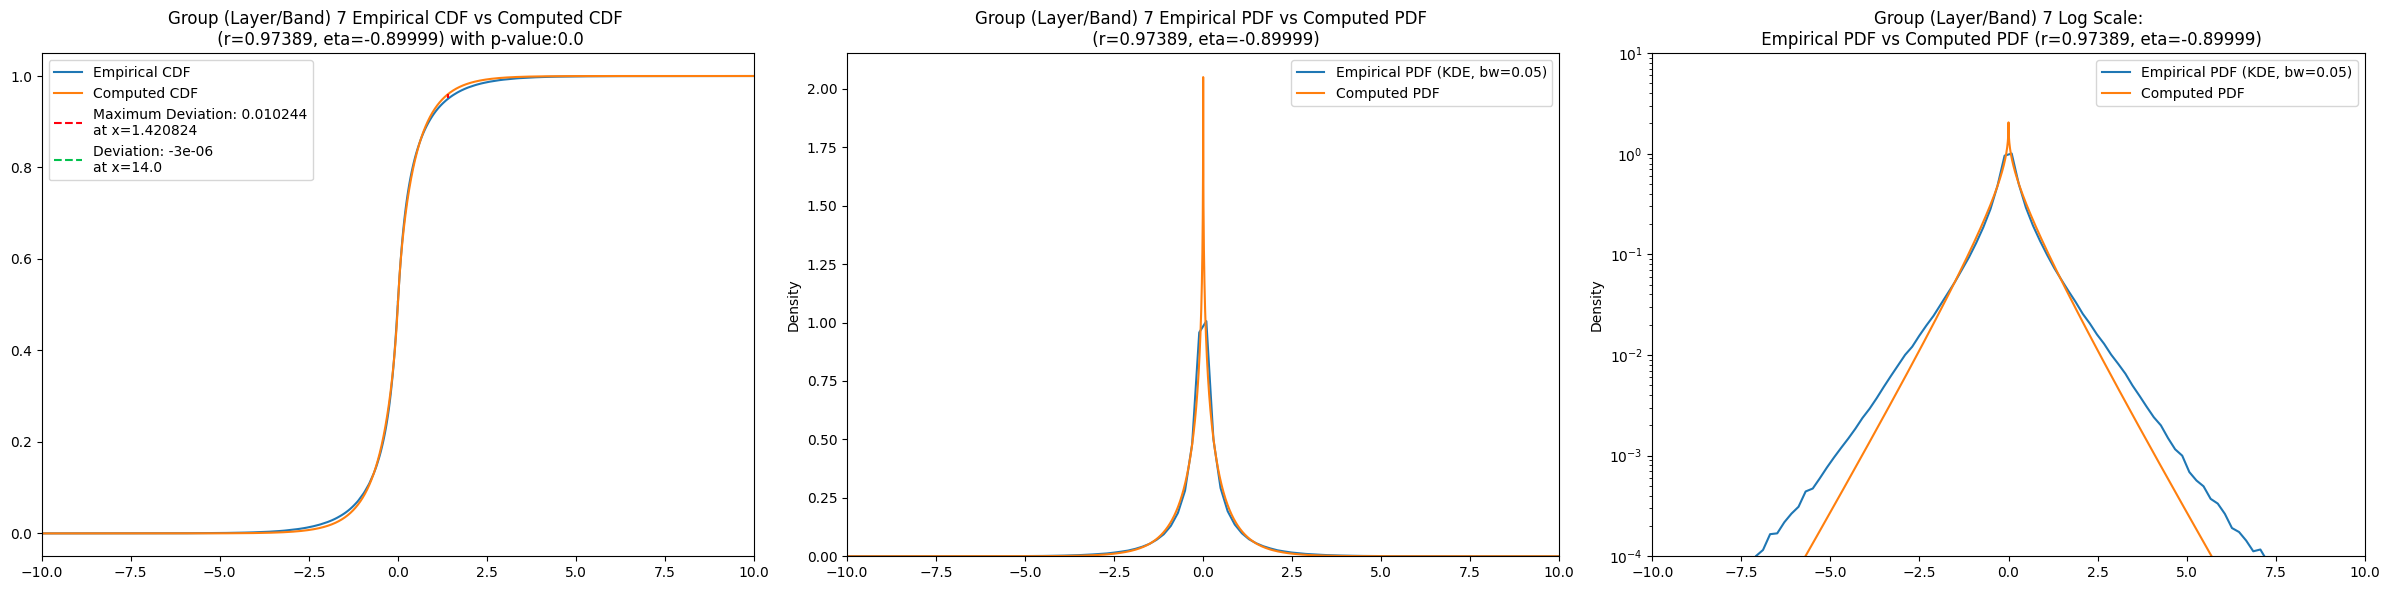

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/plotting.py:418: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


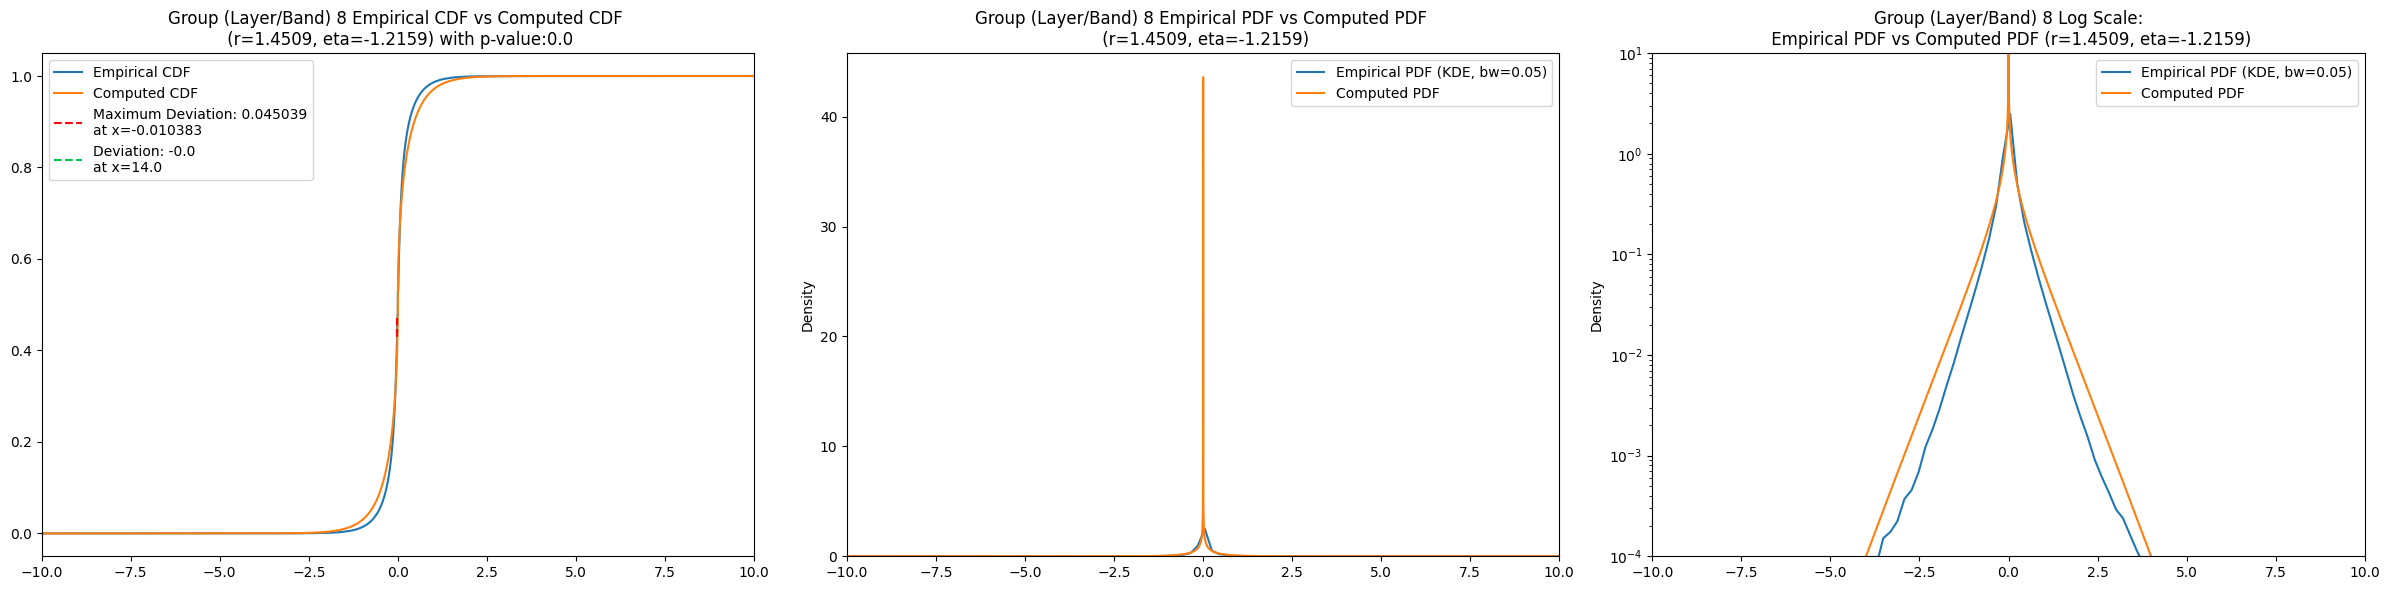

/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_77131/1136713052.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_77131/1136713052.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)


In [26]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace

In [27]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [28]:
for group in GROUPS:
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_compare_priors.csv'))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_compare_priors.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,...,27.782300,0.019503,1.755550e-01,25.439100,0.036392,4.282210e-04,20.752800,0.036305,4.458110e-04,2.798600e-01
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,...,16.031400,0.010128,1.460870e-01,14.012900,0.022665,4.151010e-06,11.277100,0.026410,3.854630e-08,9.765300e-01
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,...,8.001070,0.020474,5.852830e-19,7.104980,0.014498,1.017140e-09,5.719650,0.018489,1.538450e-15,1.159900e-01
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005235,...,3.590120,0.030175,2.012920e-161,3.138820,0.002343,2.134870e-01,2.574020,0.010572,3.454100e-20,1.049000e-02
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004347,...,1.426170,0.042370,0.000000e+00,1.246790,0.014477,1.233750e-148,1.010520,0.017937,5.988230e-228,2.874500e-09
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010412,...,0.539642,0.052925,0.000000e+00,0.472750,0.025277,0.000000e+00,0.378316,0.026436,0.000000e+00,3.257600e-297
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051527,...,0.196018,0.056353,0.000000e+00,0.172564,0.029150,0.000000e+00,0.137348,0.028144,0.000000e+00,0.000000e+00


# Examining Tail Behavior

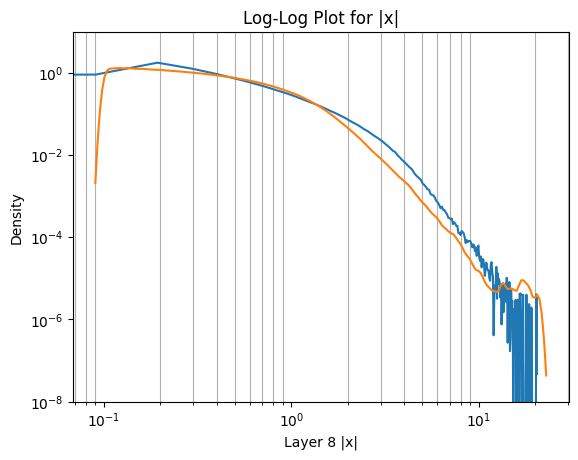

In [29]:
bw = 0.05
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(os.path.join(CWD, "plots", 'log-log_plot_layer_7.jpg'), bbox_inches = 'tight')

bw = 0.05
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(os.path.join(CWD, "plots", 'log-log_plot_layer_8.jpg'), bbox_inches = 'tight')

In [30]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
            elif distro == 'gaussian':
                cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in GROUPS:
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
/Users/brandonmarks/opt/anaconda3/envs/NewResearch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/utilities/testing.py:577: RuntimeWarning: divide by zero encountered in divide
  tail_ratios =

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,803.473892,751.378924,857.028528,0.094996,-0.097312,0.299754,3180.0,0.42,5.7,0.018069,...,"(0.1239, 1.0126)","(0.1239, 1.0126)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.018069,1.806895e-02
3,275.270192,264.590167,286.288690,0.374403,0.219221,0.546058,12720.0,0.51,7.3,0.004615,...,"(0.25381, 1.016)","(0.25381, 1.016)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.004615,3.824459e-03
4,80.847728,77.046186,84.706154,1.357251,1.030759,1.855357,50880.0,0.44,1.4,0.006270,...,"(0.098794, 1.0029)","(0.098794, 1.0029)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.005812,5.487173e-03
5,19.882305,18.762781,21.056150,3.074957,2.230657,5.079245,203520.0,0.47,0.2,0.005235,...,"(0.26121, 1.9563)","(0.26121, 1.9563)","(0.90723, 9.236e+34)","(0.98075, 9.236e+34)","(0.95007, 9.254e+46)","(0.97884, 9.254e+46)","(0.0034259, 1.0662)","(0.0034259, 1.0104)",0.003318,1.377231e-03
6,4.187365,3.884993,4.587161,7.592764,3.861297,29.028659,814080.0,0.51,-0.6,0.004347,...,"(0.12783, 1.0096)","(0.12783, 1.001)","(0.87957, 3.725e+56)","(0.99905, 3.725e+56)","(0.93638, 2.5142e+75)","(0.99905, 2.5142e+75)","(0.0013751, 1.2182)","(0.0013751, 1.0041)",0.002540,9.861080e-04
7,0.819285,0.747353,0.916054,13.123555,6.050411,48.182214,3256320.0,0.97,-0.9,0.010412,...,"(0.95916, 470240.0)","(0.99998, 470240.0)","(0.85009, 2.0712000000000005e+268)","(0.99998, 2.0712000000000005e+268)","(0.90639, inf)","(0.99998, inf)","(0.0015714, 1.506)","(0.0015714, 1.0007)",0.008438,2.408727e-05
8,0.136744,0.117431,0.211746,172.661568,8.088640,756.942474,13025280.0,1.44,-1.2,0.051527,...,"(0.31719, 7385800000000.0)","(1.0, 7385800000000.0)","(0.83652, inf)","(1.0, inf)","(0.89531, inf)","(1.0, inf)","(0.0028504, 1.7139)","(0.0028504, 1.0001)",0.002515,7.676931e-07


# Results

## KS-Test Statistics

In [31]:
import pandas as pd
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

In [32]:
master_df.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,kstest_stat_best,kstest_stat_iter1,kstest_stat_iter2,kstest_stat_iter3,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
0,3180.0,0.018069,0.024030,0.060346,0.017520,0.017542,0.017520,NaN,0.019503,0.036392,0.036305,0.018069,1.806895e-02
1,12720.0,0.004615,0.012029,0.037012,0.004221,0.004263,0.004221,NaN,0.010128,0.022665,0.026410,0.004615,3.824459e-03
2,50880.0,0.006270,0.006018,0.023319,0.005286,0.005315,0.005286,NaN,0.020474,0.014498,0.018489,0.005812,5.487173e-03
3,203520.0,0.005235,0.003010,0.005653,0.003591,0.003863,0.003595,0.003591,0.030175,0.002343,0.010572,0.003318,1.377231e-03
4,814080.0,0.004347,0.001505,0.020504,0.003536,0.003588,0.003541,0.003536,0.042370,0.014477,0.017937,0.002540,9.861080e-04
5,3256320.0,0.010412,0.000753,0.082283,0.010244,0.010250,0.010245,0.010244,0.052925,0.025277,0.026436,0.008438,2.408727e-05
6,13025280.0,0.051527,0.000376,0.227353,0.045039,0.046820,0.045082,0.045039,0.056353,0.029150,0.028144,0.002515,7.676931e-07
